In [2]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [3]:
data_dir = Path("../../data/processed")  
files = {
    "GK": data_dir / "players_data_GK_normalized.parquet",
}

def load_clean(path):
    table = pq.read_table(path)
    table = table.replace_schema_metadata(None)
    return table.to_pandas()

df_gk = load_clean(files["GK"])




# Cluster Defenders

In [4]:
print("MF shape:", df_gk.shape)
df_gk.head()
df_gk.info()
df_gk.describe()
df_gk.select_dtypes(include="object").columns

# drop_cols = ["__index_level_0__"] + ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'foot']
categorical_cols = ['Rk','Player', 'Nation', 'Pos','Squad', 'Comp', 'Age','Born','MP','Starts','Min','90s',
                    'numeric_wage', 'foot', 'W', 'D', 'L']
gk_features = df_gk.drop(columns=categorical_cols, errors="ignore")



# Print the shape and preview of the numeric dataset
print("Numeric dataset shape:", gk_features.shape)
gk_features.head()

gk_scaled = gk_features  # Data is already normalized

# Apply PCA to reduce dimensions to 2D for plotting and visualization
pca = PCA(n_components=2, random_state=42)
gk_pca = pca.fit_transform(gk_scaled)
# Apply KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42, algorithm='elkan')
gk_clusters = kmeans.fit_predict(gk_pca)

# Add cluster labels to the original dataframe for easy reference
df_gk["cluster"] = gk_clusters

MF shape: (117, 95)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 95 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Rk                        117 non-null    int64  
 1   Player                    117 non-null    object 
 2   Nation                    117 non-null    object 
 3   Pos                       117 non-null    object 
 4   Squad                     117 non-null    object 
 5   Comp                      117 non-null    object 
 6   Age                       117 non-null    float64
 7   Born                      117 non-null    float64
 8   MP                        117 non-null    int64  
 9   Starts                    117 non-null    int64  
 10  Min                       117 non-null    int64  
 11  90s                       117 non-null    float64
 12  numeric_wage              110 non-null    float64
 13  foot                      107 non-null    obj

### Plot and List

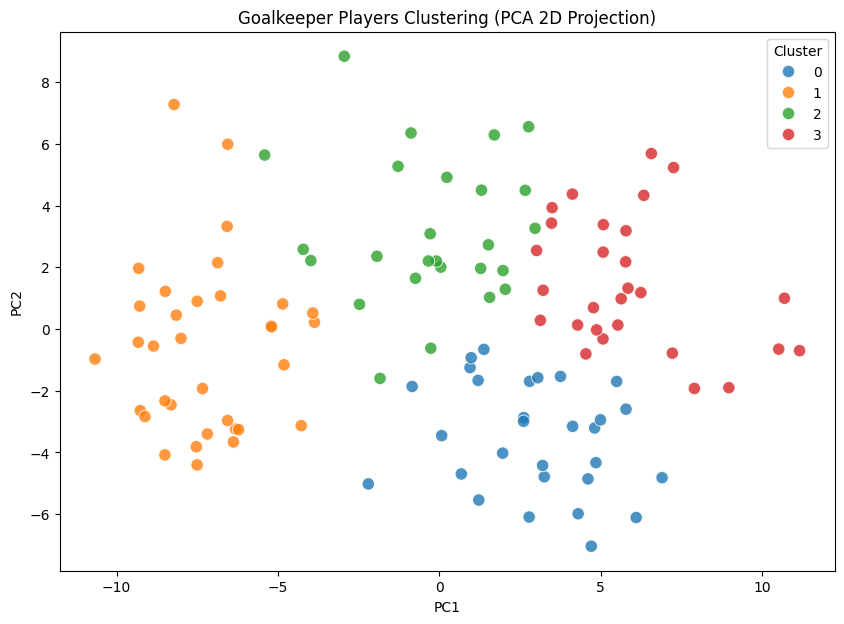

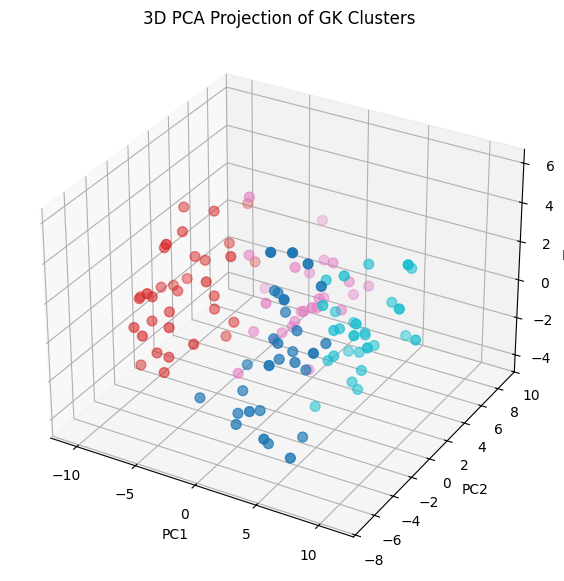

Eigenvalues (variance explained by each PC): [30.23856767 11.11898226  4.42817515]
Explained variance ratio: [0.39850873 0.1465351  0.05835814]
Cumulative variance explained: [0.39850873 0.54504383 0.60340197]


In [5]:
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=gk_pca[:,0], 
    y=gk_pca[:,1], 
    hue=df_gk["cluster"],       
    palette="tab10", 
    s=80,
    alpha=0.8
)



plt.title("Goalkeeper Players Clustering (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()



# Fit PCA for 3 components
pca_3d = PCA(n_components=3, random_state=42)
gk_pca_3d = pca_3d.fit_transform(gk_scaled)
# 3D scatter plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    gk_pca_3d[:,0], gk_pca_3d[:,1], gk_pca_3d[:,2], 
    c=df_gk["cluster"], cmap="tab10", s=50
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.title("3D PCA Projection of GK Clusters")
plt.show()

# Print eigenvalues / explained variance
print("Eigenvalues (variance explained by each PC):", pca_3d.explained_variance_)
print("Explained variance ratio:", pca_3d.explained_variance_ratio_)
print("Cumulative variance explained:", np.cumsum(pca_3d.explained_variance_ratio_))


# Evaluate Defenders

In [6]:

sil_score = silhouette_score(gk_scaled, df_gk["cluster"])
print("Silhouette Score:", sil_score)


dbi = davies_bouldin_score(gk_scaled, df_gk["cluster"])
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(gk_scaled, df_gk["cluster"])
print("Calinski-Harabasz Score:", ch_score)

# After fitting PCA
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=gk_features.columns
)

# Sort features by importance for PC1 and PC2
loadings_PC1 = loadings["PC1"].abs().sort_values(ascending=False)
loadings_PC2 = loadings["PC2"].abs().sort_values(ascending=False)

print("Top PC1 drivers:\n", loadings_PC1.head(15))
print("\nTop PC2 drivers:\n", loadings_PC2.head(15))

low_variance = gk_features.var().sort_values().head(50)
print(low_variance)

Silhouette Score: 0.1467946536109514
Davies-Bouldin Index: 1.9884405019812437
Calinski-Harabasz Score: 28.399508485057712
Top PC1 drivers:
 Touches                     0.177391
Def 3rd_stats_possession    0.177338
Att                         0.175943
exposure_score              0.175411
Min_stats_keeper            0.175289
Compl                       0.175192
Def Pen                     0.175053
MP_stats_keeper             0.175027
Starts_stats_keeper         0.174984
Min%                        0.174089
PrgDist                     0.170945
TotDist                     0.170401
TotDist_stats_possession    0.167520
Att (GK)                    0.167251
SoTA                        0.165157
Name: PC1, dtype: float64

Top PC2 drivers:
 xG+/-      0.271860
+/-90      0.270645
+/-        0.269461
xG+/-90    0.268960
PPM        0.264227
GA90       0.224972
Cmp%       0.224327
Launch%    0.220634
AvgLen     0.210098
onG        0.197593
onxG       0.190352
CS%        0.187658
CS         0.156379


# Clustering Defenders with PC1 and PC2 Feature Selection

,Selected Features
0,MP_stats_keeper
1,Saves
2,Live
3,onG
4,Opp
5,+/-90
6,xG+/-90
7,SoTA
8,TotDist
9,xG+/-


K=4: Silhouette Score = 0.2696
Davies-Bouldin Index: 1.2698915096408694
Calinski-Harabasz Score: 71.78154383128604


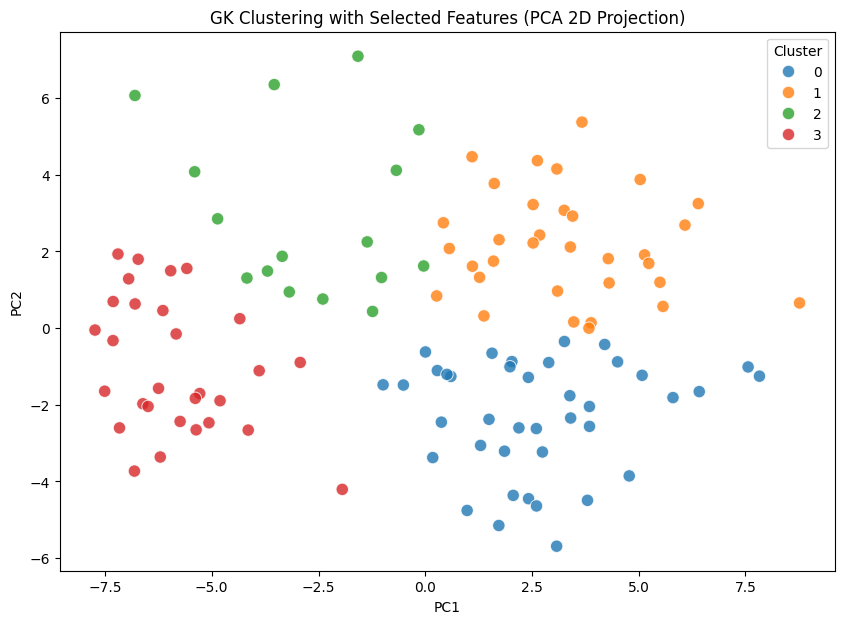

Players in cluster 0: 39


,Player,Squad,Pos,cluster
3,Alphonse Areola,West Ham,GK,0
6,Augusto Batalla,Rayo Vallecano,GK,0
7,Oliver Baumann,Hoffenheim,GK,0
8,Marco Bizot,Brest,GK,0
14,Jasper Cillessen,Las Palmas,GK,0
20,Yehvann Diouf,Reims,GK,0
21,Marko Dmitrović,Leganés,GK,0
26,Wladimiro Falcone,Lecce,GK,0
28,Yahia Fofana,Angers,GK,0
29,Joan García,Espanyol,GK,0


Players in cluster 1: 33


,Player,Squad,Pos,cluster
4,Kepa Arrizabalaga,Bournemouth,GK,1
5,Noah Atubolu,Freiburg,GK,1
10,Marcin Bułka,Nice,GK,1
12,Marco Carnesecchi,Atalanta,GK,1
13,Lucas Chevalier,Lille,GK,1
16,Thibaut Courtois,Real Madrid,GK,1
19,Michele Di Gregorio,Juventus,GK,1
27,Mark Flekken,Brentford,GK,1
30,Paulo Gazzaniga,Girona,GK,1
31,David de Gea,Fiorentina,GK,1


Players in cluster 2: 16


,Player,Squad,Pos,cluster
0,Adrián,Betis,GK,2
2,Alisson,Liverpool,GK,2
9,Jean Butez,Como,GK,2
15,Diego Conde,Villarreal,GK,2
22,Gianluigi Donnarumma,Paris S-G,GK,2
24,Ederson,Manchester City,GK,2
46,Philipp Köhn,Monaco,GK,2
65,Manuel Neuer,Bayern Munich,GK,2
66,Moritz Nicolas,Gladbach,GK,2
75,Iñaki Peña,Barcelona,GK,2


Players in cluster 3: 29


,Player,Squad,Pos,cluster
1,Julen Agirrezabala,Athletic Club,GK,3
11,Elia Caprile,Cagliari,GK,3
17,Finn Dahmen,Augsburg,GK,3
18,Arthur Desmas,Le Havre,GK,3
23,Patrick Drewes,Bochum,GK,3
25,Łukasz Fabiański,West Ham,GK,3
32,Mathieu Gorgelin,Le Havre,GK,3
40,Dinko Horkaš,Las Palmas,GK,3
41,Timo Horn,Bochum,GK,3
44,Luiz Lúcio Reis Júnior,Villarreal,GK,3


In [7]:
# Drop features with low variance and select top features from PC1 and PC2
selected_features = list(loadings_PC1.head(20).index) + list(loadings_PC2.head(10).index)
selected_features = list(set(selected_features))  # Remove duplicates
selected_features_df = pd.DataFrame(selected_features, columns=["Selected Features"])
display(selected_features_df)



gk_scaled_sel = df_gk[selected_features].copy()
# Make Nan values 0
# fw_sel = fw_sel.fillna(0)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# fw_scaled_sel = scaler.fit_transform(fw_sel)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(gk_scaled_sel)
sil = silhouette_score(gk_scaled_sel, clusters)
print(f"K=4: Silhouette Score = {sil:.4f}")

# Evaluate
dbi = davies_bouldin_score(gk_scaled_sel, clusters)
print("Davies-Bouldin Index:", dbi)

ch_score = calinski_harabasz_score(gk_scaled_sel, clusters)
print("Calinski-Harabasz Score:", ch_score)

# Add cluster labels to the original dataframe for easy reference
df_gk["cluster"] = clusters

# Plotting with selected features
pca_sel = PCA(n_components=2, random_state=42)
gk_pca_sel = pca_sel.fit_transform(gk_scaled_sel)
plt.figure(figsize=(10,7))
sns.scatterplot(
    x=gk_pca_sel[:,0], 
    y=gk_pca_sel[:,1], 
    hue=clusters,       
    palette="tab10", 
    s=80,
    alpha=0.8
)
plt.title("GK Clustering with Selected Features (PCA 2D Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# List players from cluster 1

cluster_0_players = df_gk[df_gk["cluster"] == 0][["Player", "Squad", "Pos", "cluster"]]
cluster_1_players = df_gk[df_gk["cluster"] == 1][["Player", "Squad", "Pos", "cluster"]]
cluster_2_players = df_gk[df_gk["cluster"] == 2][["Player", "Squad", "Pos", "cluster"]]
cluster_3_players = df_gk[df_gk["cluster"] == 3][["Player", "Squad", "Pos", "cluster"]]

print(f"Players in cluster 0: {len(cluster_0_players)}")
display(cluster_0_players)
print(f"Players in cluster 1: {len(cluster_1_players)}")
display(cluster_1_players)
print(f"Players in cluster 2: {len(cluster_2_players)}")
display(cluster_2_players)
print(f"Players in cluster 3: {len(cluster_3_players)}")
display(cluster_3_players)







In [10]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors

feature_cols = selected_features
X = gk_scaled_sel.values
labels = clusters

per_cluster_nn = {}
per_cluster_idx = {}

for c in np.unique(labels):
    indx = np.where(labels == c)[0]
    Xc = X[indx, :]
    # n_neighbors+1 to allow excluding self at query time
    nn = NearestNeighbors(n_neighbors=min(11, len(indx)), metric="euclidean", algorithm="auto")
    nn.fit(Xc)
    per_cluster_nn[c] = nn
    per_cluster_idx[c] = indx

def nearest_players_within_cluster(df, player_name=None, row_idx=None, k=5, id_col="Player"):
    if player_name is None and row_idx is None:
        raise ValueError("Provide either player_name or row_idx.")
    if row_idx is None:
        match = df.index[df[id_col] == player_name].tolist()
        if not match:
            raise ValueError(f"Player '{player_name}' not found in column '{id_col}'.")
        row_idx = match[0]

    c = labels[row_idx]
    nn = per_cluster_nn[c]
    idx = per_cluster_idx[c]

    xq = X[row_idx].reshape(1, -1)
    n_q = min(k+1, len(idx))
    dists, inds = nn.kneighbors(xq, n_neighbors=n_q)
    dists, inds = dists[0], inds[0]

    global_inds = idx[inds]
    mask = global_inds != row_idx
    global_inds = global_inds[mask]
    dists = dists[mask]
    global_inds = global_inds[:k]
    dists = dists[:k]

    cols_to_show = [c for c in [id_col, "Rk", "Pos", "Squad", "cluster"] if c in df.columns]
    out = df.iloc[global_inds][cols_to_show].copy()
    out["distance"] = dists
    return out.reset_index(drop=True)

# Example usage:
display(nearest_players_within_cluster(df_gk, player_name="Thibaut Courtois", k=10))


,Player,Rk,Pos,Squad,cluster,distance
0,Marco Carnesecchi,491,GK,Atalanta,1,2.407961
1,Lukáš Hrádecký,1186,GK,Leverkusen,1,2.499166
2,Alex Meret,1725,GK,Napoli,1,2.562604
3,Michele Di Gregorio,705,GK,Juventus,1,2.698509
4,Jan Oblak,1939,GK,Atlético Madrid,1,2.706577
5,Lucas Chevalier,544,GK,Lille,1,2.876376
6,Gerónimo Rulli,2277,GK,Marseille,1,3.039149
7,Marcin Bułka,426,GK,Nice,1,3.096233
8,Lucas Perri,2099,GK,Lyon,1,3.159360
9,Yann Sommer,2471,GK,Inter,1,3.273521
